#Segundo intento#



*   Solo con los datos de Madrid de Idealista2018
*   Madrid_Sale.csv y Madrid_Polygons.rda bajados de https://github.com/paezha/idealista18/tree/e2cfe3f621e1c37f226ce956f61b7306c42d5721/data


*   archivo Madrid_Polygons.rda transformado en csv con Notebook en R Script R rda a csv.ipyn https://colab.research.google.com/drive/1I06zwKUreseL1p87dHq0TzMheUHiEmVc


*   Exploración de datos (EDA) copiado de https://github.com/enricobonii/Idealista-Project/blob/main/IdealistaProject%20v4.ipynb
*Agregar la Columna neighbourhood a df_Madrid: de la latitud y longitud de cada casa se busca el barrio al que corresponde en Madrid_Polygons.csv


* a Madrid_Polygons se le añade la columna mean_UNITPRICE para utilizarla posteriormente para calcular precios de casas en 2024.

* Se intenta bajar la geometria de la M30, para calcular la distancia de los pisos a esta, y para definir si están dentro de la M30 o fuera. Como no funciona porque los datos de la M30 incluyen las carreteras radiales, y no se cierra, en las próximas versiones se desechará la M30

* Se calcula el número de estaciones de Metro que hay en un radio de 500m alrededor de cada casa, y se guarda en la nueva columna metro_within_500m

* finalmente, se guarda el dataframe como gdf_Madrid_with_metro_count.csv en el Google drive asi como Madrid_Polygons_with_mean_unitprice.csv

* lo siguiente, Multivariate Analysis etc. copiado de https://github.com/enricobonii/Idealista-Project/blob/main/IdealistaProject%20v4.ipynb no se ha tocado de momento





In [17]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

# Ruta al archivo CSV en Google Drive
file_path = '/content/drive/My Drive/Idealista_2024/datos_2018/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from getpass import getpass
import os

# Solicita el token personal de GitHub
token = getpass('GitHub Token: ')

# Define la URL del repositorio y la ruta de clonación
repo_url = "https://github.com/edouardor/Idealista_2024.git"
destino = "/content/drive/MyDrive/Idealista_2024"

# Clona el repositorio en la carpeta de Google Drive
os.system(f'git clone https://{token}@github.com/edouardor/Idealista_2024.git {destino}')


GitHub Token: ··········


32768

In [7]:
!ls -a


datos_2018  datos_2024	.git  .ipynb_checkpoints  Notebooks  README.md


In [12]:
!git config --global user.email "edouardo@hotmail.es"
!git config --global user.name "edouardor"

In [13]:
# Agregar los archivos modificados
!git add .

# Hacer un commit
!git commit -m "Actualización desde Google Colab"

# Hacer push de los cambios
!git push


[main 7c8d851] Actualización desde Google Colab
 8 files changed, 175914 insertions(+)
 create mode 100644 Notebooks/Idealista Madrid github.ipynb
 create mode 100644 datos_2018/Madrid_POIS.csv
 create mode 100644 datos_2018/Madrid_Polygons.csv
 create mode 100644 datos_2018/Madrid_Polygons_with_mean_unitprice.csv
 create mode 100644 datos_2018/Madrid_sale.csv
 create mode 100644 datos_2018/gdf_Madrid_with_metro_count.csv
 create mode 100644 datos_2024/precio medio distritos 2024.xlsx
 create mode 100644 datos_2024/precio metro 2024 fotocasa.csv
Enumerating objects: 14, done.
Counting objects: 100% (14/14), done.
Delta compression using up to 2 threads
Compressing objects: 100% (13/13), done.
Writing objects: 100% (13/13), 9.76 MiB | 2.02 MiB/s, done.
Total 13 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), done.
To https://github.com/edouardor/Idealista_2024.git
   aecb357..7c8d851  main -> main


In [14]:
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from math import radians, cos, sin, asin, sqrt
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

pd.set_option('display.max_columns', None)

## Initializing Datasets

###Solo Madrid


In [18]:

df= pd.read_csv(file_path+'gdf_Madrid_with_metro_count.csv')


In [19]:
df.head(3)

,ASSETID,PERIOD,PRICE,UNITPRICE,ADTYPOLOGYID,ADOPERATIONID,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,HASLIFT,HASAIRCONDITIONING,AMENITYID,HASPARKINGSPACE,HASNORTHORIENTATION,HASSOUTHORIENTATION,HASEASTORIENTATION,HASWESTORIENTATION,HASBOXROOM,HASWARDROBE,HASSWIMMINGPOOL,HASDOORMAN,HASGARDEN,ISDUPLEX,ISSTUDIO,ISINTOPFLOOR,FLOORCLEAN,FLATLOCATIONID,CADCONSTRUCTIONYEAR,CADMAXBUILDINGFLOOR,CADDWELLINGCOUNT,CADASTRALQUALITYID,BUILTTYPEID_1,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_STREET,LONGITUDE,LATITUDE,CITYNAME,ADTYPOLOGY,ADOPERATION,neighbourhood,metros_within_500m
0,A2624736749193113090,4,166000,1844.444444,HOME,SALE,90,2,1,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,1.0,1986,10,32,5.0,0,0,1,7.953755,0.402011,6.504196,-3.611866,40.431013,Madrid,HOME,SALE,Hellín,2
1,A8841356095019025740,3,133000,1727.272727,HOME,SALE,77,3,1,1,1,1,3,0,0,1,1,0,0,0,0,0,0,0,0,0,3.0,1.0,1960,4,80,7.0,0,0,1,7.443821,0.480740,5.961369,-3.618239,40.431754,Madrid,HOME,SALE,Hellín,1
2,A6716251930495709236,3,98000,1719.298246,HOME,SALE,57,2,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1960,4,9,7.0,0,0,1,7.473113,0.287270,6.039694,-3.617411,40.430101,Madrid,HOME,SALE,Hellín,1


## Exploratory Data Analysis

In [20]:
print(df.dtypes)

ASSETID                     object
PERIOD                       int64
PRICE                        int64
UNITPRICE                  float64
ADTYPOLOGYID                object
ADOPERATIONID               object
CONSTRUCTEDAREA              int64
ROOMNUMBER                   int64
BATHNUMBER                   int64
HASTERRACE                   int64
HASLIFT                      int64
HASAIRCONDITIONING           int64
AMENITYID                    int64
HASPARKINGSPACE              int64
HASNORTHORIENTATION          int64
HASSOUTHORIENTATION          int64
HASEASTORIENTATION           int64
HASWESTORIENTATION           int64
HASBOXROOM                   int64
HASWARDROBE                  int64
HASSWIMMINGPOOL              int64
HASDOORMAN                   int64
HASGARDEN                    int64
ISDUPLEX                     int64
ISSTUDIO                     int64
ISINTOPFLOOR                 int64
FLOORCLEAN                 float64
FLATLOCATIONID             float64
CADCONSTRUCTIONYEAR 

From here we can observe that the formatted variable types make sense with the expected and are homogeneous among the different datasets.

In [21]:
df.describe(include='all')

,ASSETID,PERIOD,PRICE,UNITPRICE,ADTYPOLOGYID,ADOPERATIONID,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,HASLIFT,HASAIRCONDITIONING,AMENITYID,HASPARKINGSPACE,HASNORTHORIENTATION,HASSOUTHORIENTATION,HASEASTORIENTATION,HASWESTORIENTATION,HASBOXROOM,HASWARDROBE,HASSWIMMINGPOOL,HASDOORMAN,HASGARDEN,ISDUPLEX,ISSTUDIO,ISINTOPFLOOR,FLOORCLEAN,FLATLOCATIONID,CADCONSTRUCTIONYEAR,CADMAXBUILDINGFLOOR,CADDWELLINGCOUNT,CADASTRALQUALITYID,BUILTTYPEID_1,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_STREET,LONGITUDE,LATITUDE,CITYNAME,ADTYPOLOGY,ADOPERATION,neighbourhood,metros_within_500m
count,75740,75740.000000,7.574000e+04,75740.000000,75740,75740,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740,75740,75740,75740,75740.000000
unique,75740,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,135,NaN
top,A2624736749193113090,NaN,NaN,NaN,HOME,SALE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Madrid,HOME,SALE,Lavapiés-Embajadores,NaN
freq,1,NaN,NaN,NaN,75740,75740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75740,75740,75740,2947,NaN
mean,NaN,2.784500,3.885028e+05,3632.521702,NaN,NaN,100.217586,2.570148,1.570240,0.351149,0.689213,0.439041,2.924835,0.216794,0.104383,0.231344,0.196343,0.142831,0.249908,0.563982,0.141907,0.247320,0.176657,0.025297,0.027079,0.021495,2.714840,0.871283,1965.446409,6.360536,38.695801,4.870399,0.031780,0.186903,0.781318,4.474552,0.469338,2.675121,-3.686323,40.420673,NaN,NaN,NaN,NaN,1.457182
std,NaN,1.209515,4.124885e+05,1708.417808,NaN,NaN,66.433670,1.246913,0.835428,0.477332,0.462819,0.496273,0.313232,0.412064,0.305759,0.421695,0.397233,0.349902,0.432962,0.495893,0.348957,0.431457,0.381381,0.157027,0.162316,0.145027,2.211571,0.334888,28.916426,2.843000,53.290795,1.460220,0.175414,0.389836,0.413355,2.669527,0.593230,2.199341,0.038916,0.033458,NaN,NaN,NaN,NaN,1.314439
min,NaN,1.000000,2.100000e+04,805.309734,NaN,NaN,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,1623.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.007647,0.001416,0.001435,-3.832534,40.328682,NaN,NaN,NaN,NaN,0.000000
25%,NaN,2.000000,1.570000e+05,2200.000000,NaN,NaN,62.000000,2.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1955.000000,5.000000,12.000000,4.000000,0.000000,0.000000,1.000000,2.401815,0.212906,1.040583,-3.708313,40.396519,NaN,NaN,NaN,NaN,0.000000
50%,NaN,3.000000,2.560000e+05,3440.000000,NaN,NaN,82.000000,3.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1967.000000,6.000000,21.000000,5.000000,0.000000,0.000000,1.000000,4.112561,0.329996,1.961970,-3.694002,40.423025,NaN,NaN,NaN,NaN,1.000000
75%,NaN,4.000000,4.560000e+05,4719.558389,NaN,NaN,115.000000,3.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,1983.000000,8.000000,39.000000,6.000000,0.000000,0.000

In [22]:
# prompt: drop observertions where df[df['ROOMNUMBER']>20]

df = df[df['ROOMNUMBER'] <= 20]

## Multivariate Analysis

In [ ]:
# Correlation analysis
'''
#CHANGE THE COLUMN CADCONSTRUCTIONYEAR datatype from int to year
df_Barcelona['CADCONSTRUCTIONYEAR'] = pd.to_datetime(df_Barcelona['CADCONSTRUCTIONYEAR'], format='%Y')
df_Barcelona['CADCONSTRUCTIONYEAR'] = df_Barcelona['CADCONSTRUCTIONYEAR'].dt.year

#Add a column CadBuildingAge in barcelona dataset where age is current year - cadconstructionyear
barcelona['CADBUILDINGAGE'] = dt.datetime.now().year - barcelona['CADCONSTRUCTIONYEAR']
barcelona = barcelona.drop(columns=['CADCONSTRUCTIONYEAR'])
'''

"\n#CHANGE THE COLUMN CADCONSTRUCTIONYEAR datatype from int to year\ndf_Barcelona['CADCONSTRUCTIONYEAR'] = pd.to_datetime(df_Barcelona['CADCONSTRUCTIONYEAR'], format='%Y')\ndf_Barcelona['CADCONSTRUCTIONYEAR'] = df_Barcelona['CADCONSTRUCTIONYEAR'].dt.year\n\n#Add a column CadBuildingAge in barcelona dataset where age is current year - cadconstructionyear\nbarcelona['CADBUILDINGAGE'] = dt.datetime.now().year - barcelona['CADCONSTRUCTIONYEAR']\nbarcelona = barcelona.drop(columns=['CADCONSTRUCTIONYEAR'])\n"

As per the above table, we can see that the columns CONSTRUCTEDAREA, BATHNUMBER, ROOMNUMBER, HASPARKINGSPACE, DISTANCE_TO_DIAGONAL, CADASTRALQUALITYID, ISPARKINGSPACEINCLUDEDINPRICE, HASDOORMAN, HASLIFT, HASTERRACE are some of the columns that have a higher correlation with the PRICE of the asset listed.


<Figure size 1600x1100 with 0 Axes>

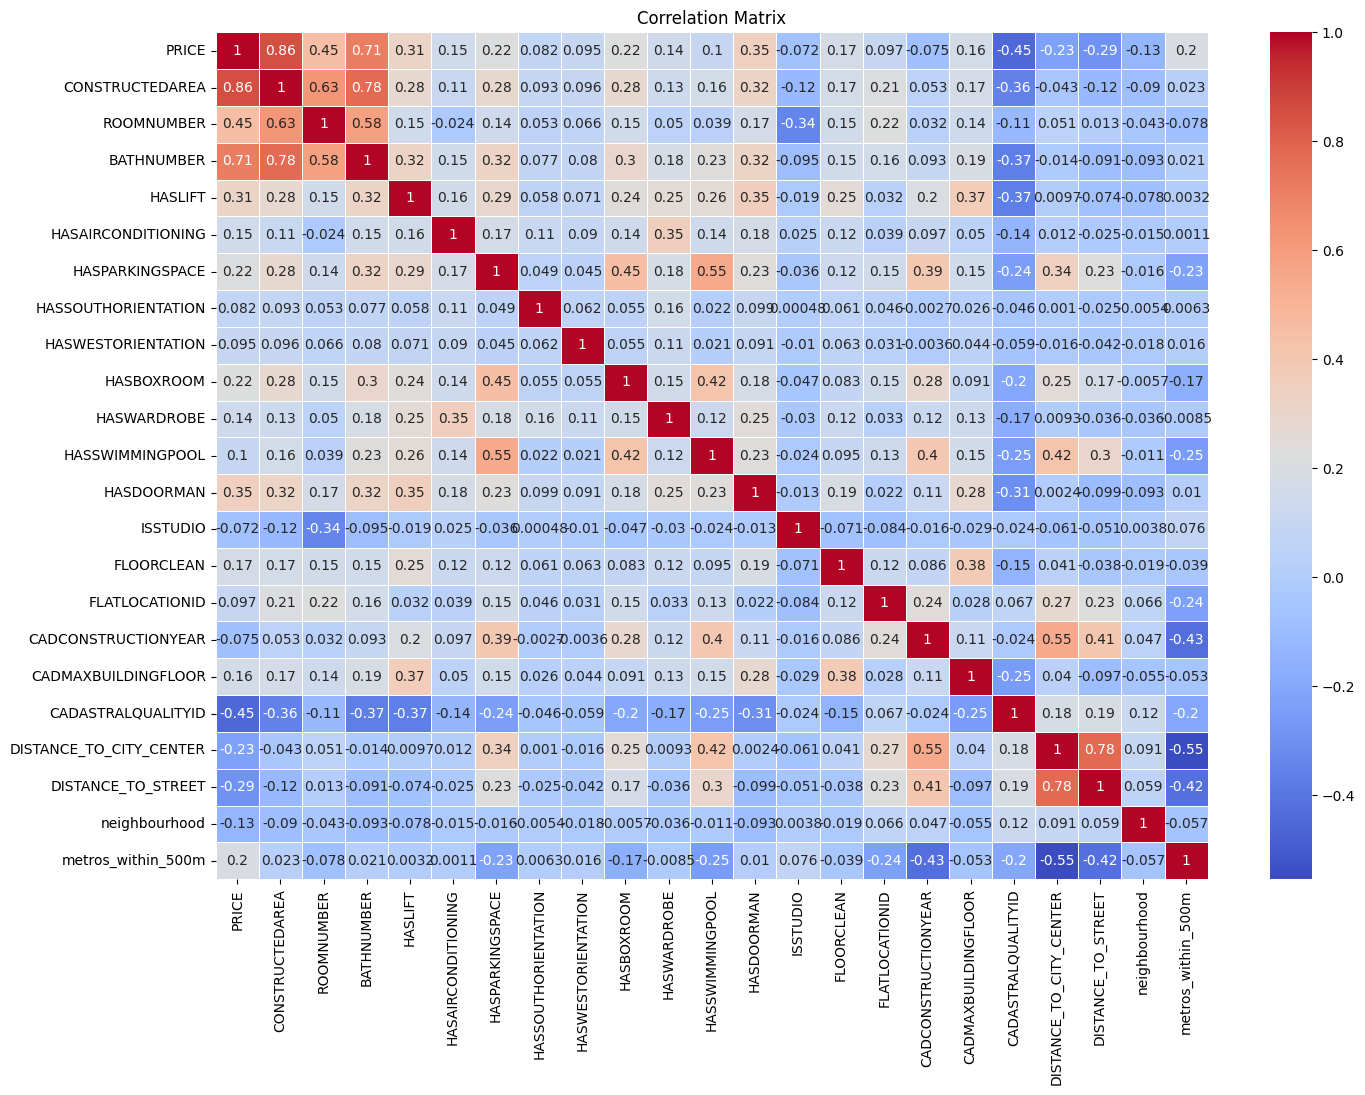

In [ ]:
madrid = df.drop(columns=['ADOPERATIONID', 'UNITPRICE', 'LATITUDE', 'LONGITUDE','AMENITYID','ASSETID','ADTYPOLOGY','CITYNAME','ADOPERATION','ADTYPOLOGYID'])

# Encode the location names (label encoding)
madrid['neighbourhood'] = df['neighbourhood'].astype('category').cat.codes

plt.figure(figsize=(16, 11))
correlation_madrid = madrid.corr()

# Identify columns where absolute correlation with 'PRICE' is less than 0.07
low_corr_columns = correlation_madrid['PRICE'][abs(correlation_madrid['PRICE']) < 0.07].index

# Drop the identified columns from the DataFrame
madrid_filtered = madrid.drop(columns=low_corr_columns)

plt.figure(figsize=(16, 11))
correlation_madrid = madrid_filtered.corr()
sns.heatmap(correlation_madrid, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
print(madrid.dtypes)

PERIOD                       int64
PRICE                        int64
CONSTRUCTEDAREA              int64
ROOMNUMBER                   int64
BATHNUMBER                   int64
HASTERRACE                   int64
HASLIFT                      int64
HASAIRCONDITIONING           int64
HASPARKINGSPACE              int64
HASNORTHORIENTATION          int64
HASSOUTHORIENTATION          int64
HASEASTORIENTATION           int64
HASWESTORIENTATION           int64
HASBOXROOM                   int64
HASWARDROBE                  int64
HASSWIMMINGPOOL              int64
HASDOORMAN                   int64
HASGARDEN                    int64
ISDUPLEX                     int64
ISSTUDIO                     int64
ISINTOPFLOOR                 int64
FLOORCLEAN                 float64
FLATLOCATIONID             float64
CADCONSTRUCTIONYEAR          int64
CADMAXBUILDINGFLOOR          int64
CADDWELLINGCOUNT             int64
CADASTRALQUALITYID         float64
BUILTTYPEID_1                int64
BUILTTYPEID_2       

In [ ]:
# print list of columns from correlation matrix in decreasing order of correlation with Price
correlation_madrid['PRICE'].sort_values(ascending=False)

,PRICE
PRICE,1.000000
CONSTRUCTEDAREA,0.856449
BATHNUMBER,0.712028
ROOMNUMBER,0.453260
HASDOORMAN,0.345089
HASLIFT,0.314883
HASBOXROOM,0.221065
HASPARKINGSPACE,0.215094
metros_within_500m,0.196746
FLOORCLEAN,0.173260


As per the above table, in Madrid,, we can see that the columns CONSTRUCTEDAREA, BATHNUMBER, ROOMNUMBER, HASDOORMAN, HASLIFT, HASPARKINGSPACE, metro_within_500 m, FloorClean are some of the columns that have a higher correlation with the PRICE of the asset listed.

**Analysing the pricing of assets based on location**

<ipython-input-10-91ba5e97af2c>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='UNITPRICE', y='neighbourhood', data=average_prices, palette='viridis')


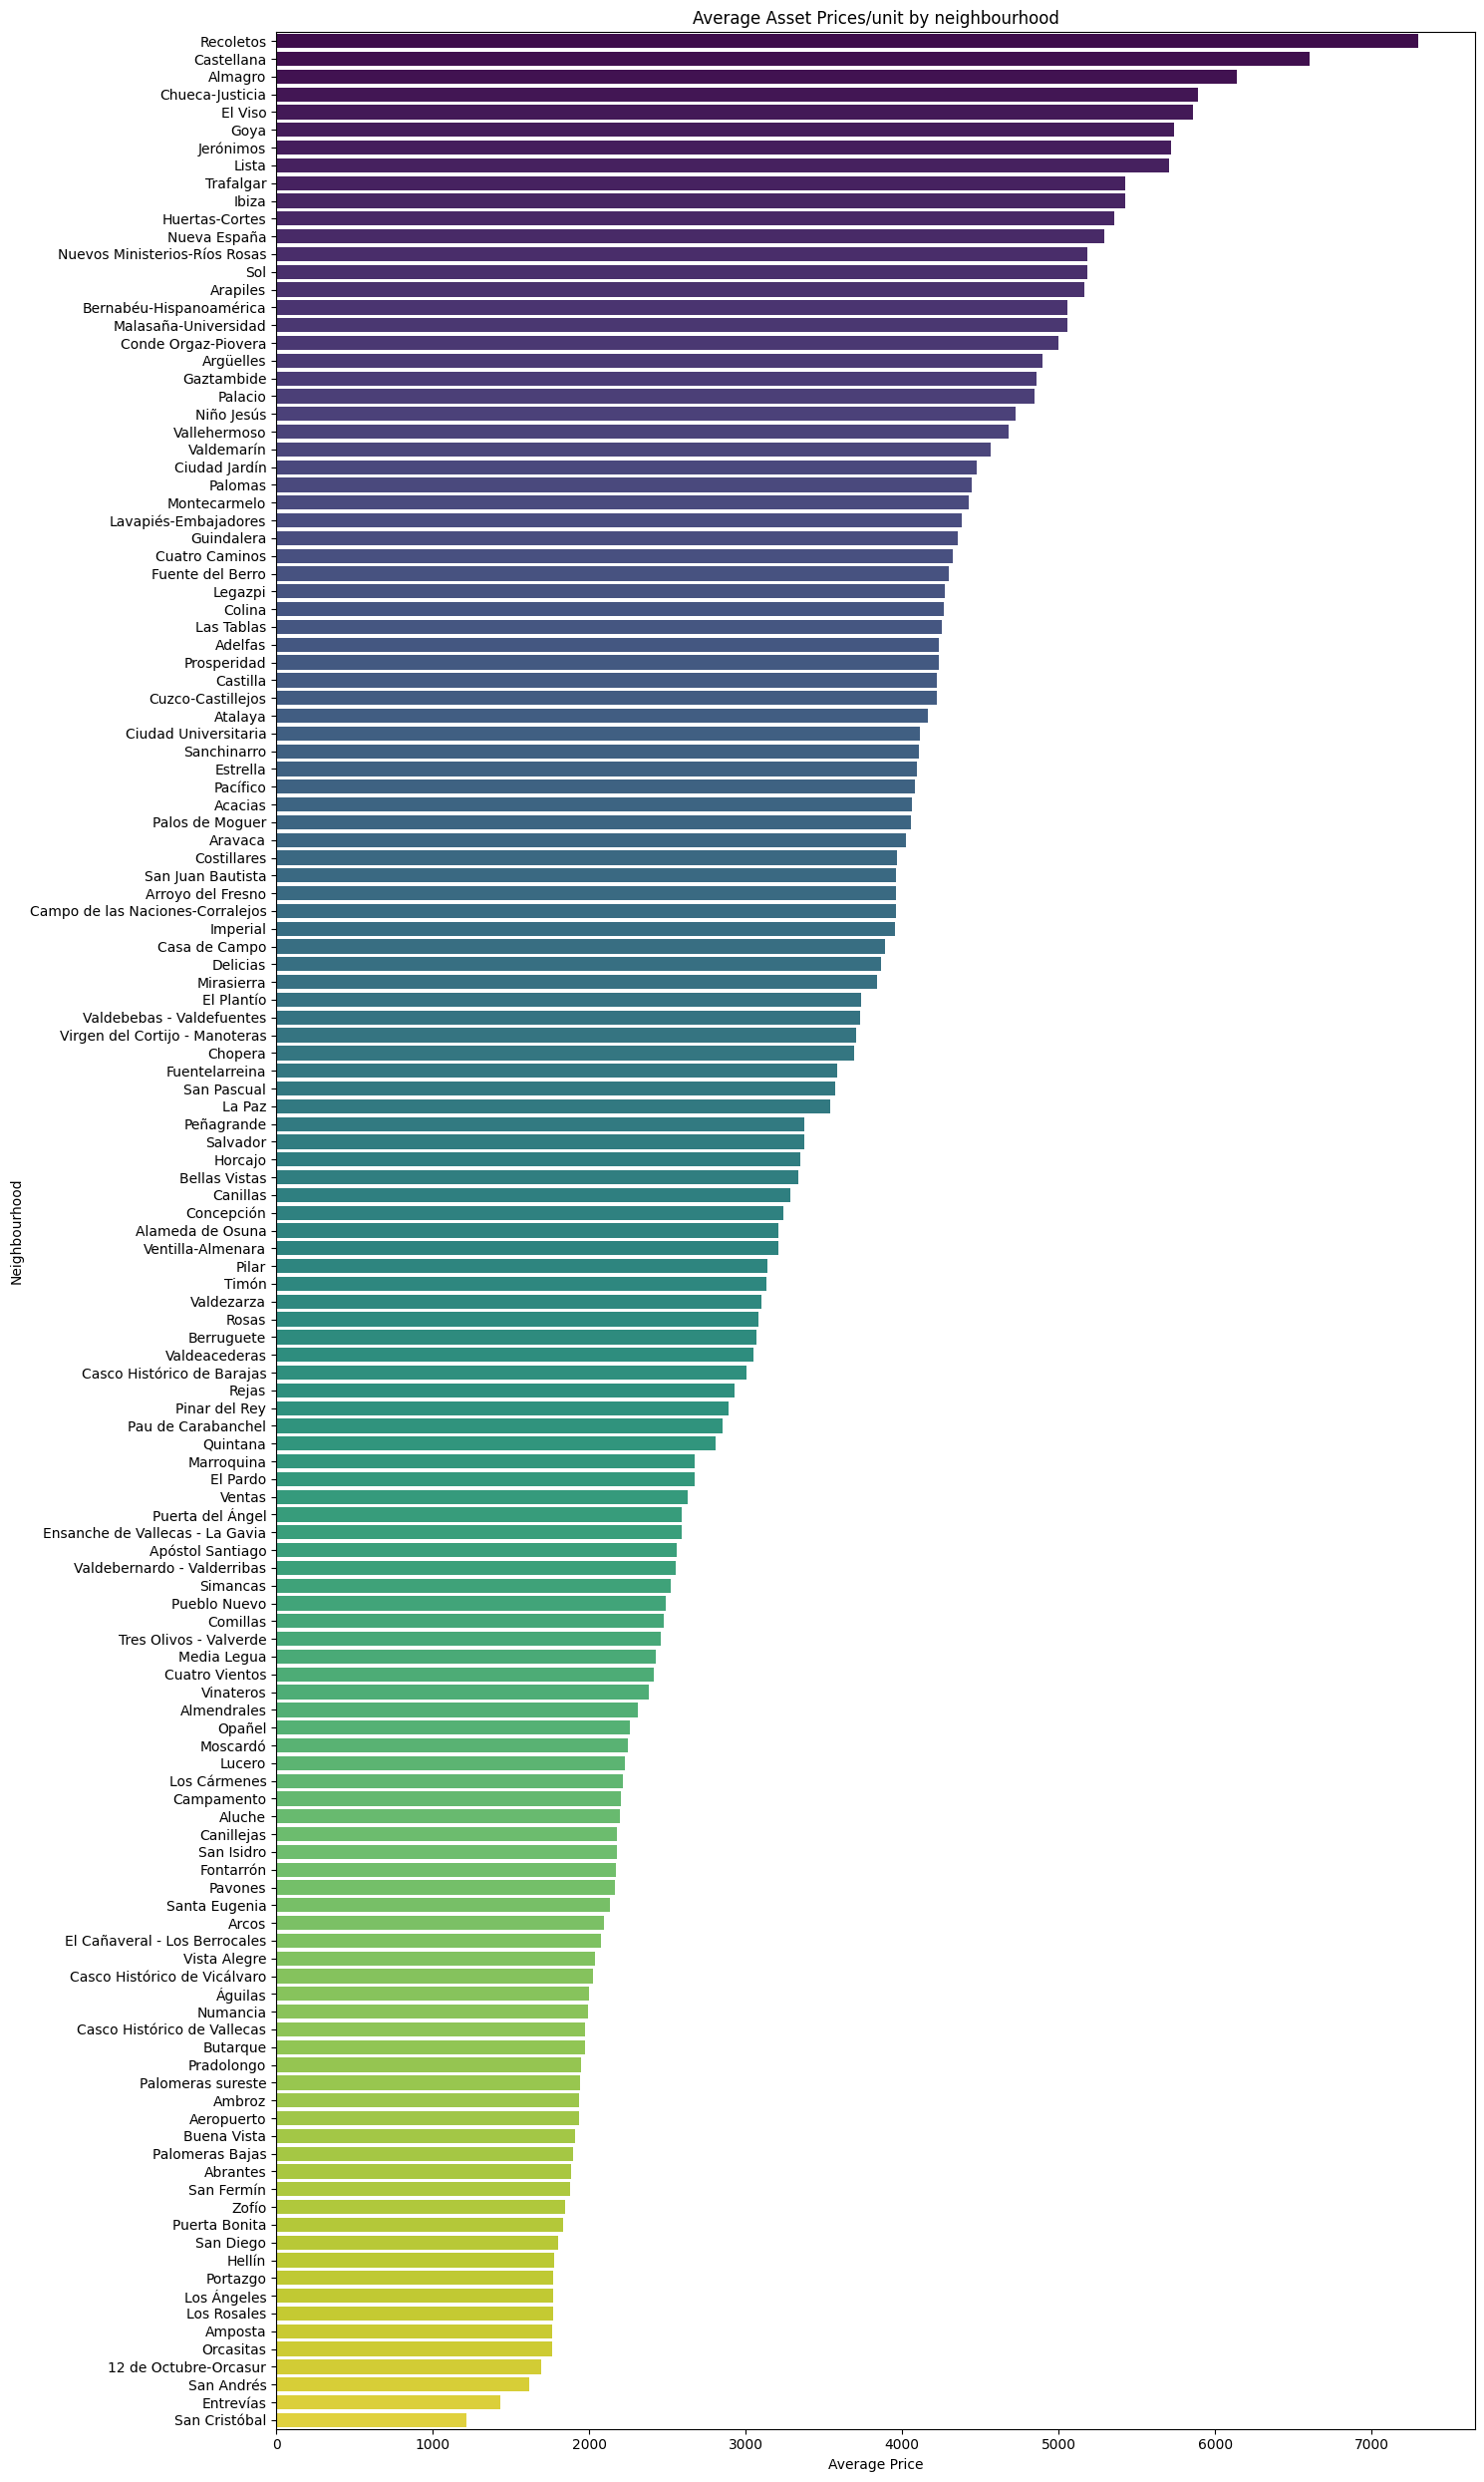

In [ ]:
madrid_unit = df.copy()
# Encode the location names (label encoding)
madrid_unit['neighbourhood'] = df['neighbourhood'].astype('category').cat.codes

# Calculate average price by neighbourhood
average_prices = madrid_unit.groupby('neighbourhood')['UNITPRICE'].mean().reset_index()

#Map the neighbourhoods to their respective names
neighbourhood_map = dict(zip(madrid_unit['neighbourhood'], df['neighbourhood']))
average_prices['neighbourhood'] = average_prices['neighbourhood'].map(neighbourhood_map)

# Sort the neighbourhoods by average price in descending order
average_prices = average_prices.sort_values(by='UNITPRICE', ascending=False)

# Plot the average prices by neighbourhood
plt.figure(figsize=(15, 25))
sns.barplot(x='UNITPRICE', y='neighbourhood', data=average_prices, palette='viridis')

plt.title('Average Asset Prices/unit by neighbourhood')
plt.ylabel('Neighbourhood')
plt.xlabel('Average Price')
plt.tight_layout()

# Show the plot
plt.show()

As we see above, in Madrid, the neighbourhoods with the highest average asset unit prices (price per meter square) are: Recoletos, Castellana, Almagro, and Chueca. So the asset to be listed in/around these areas can have a high asking price (around 6500/m2). Places such as San Andres, Entrevias or San Cristobal have the lowest average asset prices. So the asset to be listed in/around these areas can have a low asking price (around 1300/m2).

In [ ]:
madrid_unit['neighbourhood'].value_counts()

,count
neighbourhood,
67,2947
74,2094
57,1636
58,1483
100,1395
...,...
4,35
60,33
48,32


In [ ]:
df_Madrid = df.copy()

## ML Models

In [ ]:
df_Madrid['PRICE'] = df_Madrid['PRICE'].apply(lambda x: np.log(x) if x > 0 else 0)

In [ ]:
def target_encode(df, target_col, cat_col):
    target_mean = df.groupby(cat_col)[target_col].mean()
    return df[cat_col].map(target_mean)


df_Madrid['NEIGHBOURHOOD_ENCODED'] = target_encode(df_Madrid, 'PRICE', 'neighbourhood')


df_Madrid.dropna(inplace=True)


In [ ]:
df_Madrid.head()

,ASSETID,PERIOD,PRICE,UNITPRICE,ADTYPOLOGYID,ADOPERATIONID,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,HASLIFT,HASAIRCONDITIONING,AMENITYID,HASPARKINGSPACE,HASNORTHORIENTATION,HASSOUTHORIENTATION,HASEASTORIENTATION,HASWESTORIENTATION,HASBOXROOM,HASWARDROBE,HASSWIMMINGPOOL,HASDOORMAN,HASGARDEN,ISDUPLEX,ISSTUDIO,ISINTOPFLOOR,FLOORCLEAN,FLATLOCATIONID,CADCONSTRUCTIONYEAR,CADMAXBUILDINGFLOOR,CADDWELLINGCOUNT,CADASTRALQUALITYID,BUILTTYPEID_1,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_STREET,LONGITUDE,LATITUDE,CITYNAME,ADTYPOLOGY,ADOPERATION,neighbourhood,metros_within_500m,NEIGHBOURHOOD_ENCODED
0,A2624736749193113090,4,12.019743,1844.444444,HOME,SALE,90,2,1,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,1.0,1986,10,32,5.0,0,0,1,7.953755,0.402011,6.504196,-3.611866,40.431013,Madrid,HOME,SALE,Hellín,2,11.692994
1,A8841356095019025740,3,11.798104,1727.272727,HOME,SALE,77,3,1,1,1,1,3,0,0,1,1,0,0,0,0,0,0,0,0,0,3.0,1.0,1960,4,80,7.0,0,0,1,7.443821,0.480740,5.961369,-3.618239,40.431754,Madrid,HOME,SALE,Hellín,1,11.692994
2,A6716251930495709236,3,11.492723,1719.298246,HOME,SALE,57,2,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1960,4,9,7.0,0,0,1,7.473113,0.287270,6.039694,-3.617411,40.430101,Madrid,HOME,SALE,Hellín,1,11.692994
3,A1897858214850462442,4,11.736069,2016.129032,HOME,SALE,62,3,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,1.0,1960,5,11,7.0,0,0,1,7.613618,0.153489,6.203659,-3.615529,40.429363,Madrid,HOME,SALE,Hellín,1,11.692994
4,A602619672115044517,3,11.617285,1947.368421,HOME,SALE,57,2,1,0,0,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0,2.0,1.0,1960,4,17,7.0,0,0,1,7.328904,0.507474,5.855577,-3.619509,40.431351,Madrid,HOME,SALE,Hellín,0,11.692994


In [ ]:
# prompt: correlation in df_Madrid between Price and NEIGHBOURHOOD_ENCODED

correlation = df_Madrid['PRICE'].corr(df_Madrid['NEIGHBOURHOOD_ENCODED'])
print(f"Correlation between Price and NEIGHBOURHOOD_ENCODED: {correlation}")

Correlation between Price and NEIGHBOURHOOD_ENCODED: 0.7603547048899034


In [ ]:
columns_to_drop = ['ASSETID', 'LONGITUDE', 'LATITUDE', 'MONTH_201803', 'MONTH_201806', 'MONTH_201809', 'MONTH_201812', 'neighbourhood', 'geometry','UNITPRICE','HASSOUTHORIENTATION','HASEASTORIENTATION','HASWESTORIENTATION','ISINTOPFLOOR']

df_Barcelona = df_Barcelona.drop(columns=columns_to_drop)

df_Madrid = df_Madrid.drop(columns=columns_to_drop)

df_Valencia = df_Valencia.drop(columns=columns_to_drop)

In [ ]:
df_Barcelona.head()

,PRICE,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,HASLIFT,HASAIRCONDITIONING,AMENITYID,HASPARKINGSPACE,HASNORTHORIENTATION,HASBOXROOM,HASWARDROBE,HASSWIMMINGPOOL,HASDOORMAN,HASGARDEN,ISDUPLEX,ISSTUDIO,FLOORCLEAN,FLATLOCATIONID,CADCONSTRUCTIONYEAR,CADMAXBUILDINGFLOOR,CADDWELLINGCOUNT,CADASTRALQUALITYID,BUILTTYPEID_1,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_DIAGONAL,metro_within_500,NEIGHBOURHOOD_ENCODED
0,12.685408,84,4,1,1,1,1,3,0,0,0,0,0,0,0,0,0,4.0,1.0,1972,9,13,4,0,0,1,1.876290,0.354004,1.475264,11,12.903125
4,12.980800,111,4,2,1,1,1,3,0,0,0,0,0,0,0,0,0,2.0,1.0,1970,8,60,2,0,0,1,2.333066,0.101568,1.200265,15,12.903125
12,13.918969,192,3,3,1,1,1,2,0,0,0,1,0,0,0,0,0,0.0,1.0,1980,4,10,3,0,0,1,0.574150,0.196765,0.713400,19,13.110030
14,13.104199,98,3,2,0,1,1,3,0,0,0,0,0,0,0,0,0,1.0,1.0,1972,10,32,3,0,0,1,2.177991,0.076963,0.854869,8,12.903125
18,12.923912,85,3,2,0,1,1,3,0,0,0,0,0,1,0,0,0,1.0,1.0,1970,10,32,3,0,0,1,2.262351,0.148700,0.858770,8,12.903125


In [ ]:
'''
columns_to_keep = [
    'PRICE', 'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER', 'HASTERRACE',
    'HASLIFT', 'HASAIRCONDITIONING', 'HASSWIMMINGPOOL', 'ISSTUDIO',
    'ISINTOPFLOOR', 'HASPARKINGSPACE', 'DISTANCE_TO_CITY_CENTER',
    'DISTANCE_TO_METRO','NEIGHBOURHOOD_ENCODED','metro_within_500'
]

df_Barcelona = df_Barcelona[columns_to_keep]
df_Madrid = df_Madrid[columns_to_keep]
df_Valencia = df_Valencia[columns_to_keep]
'''

"\ncolumns_to_keep = [\n    'PRICE', 'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER', 'HASTERRACE',\n    'HASLIFT', 'HASAIRCONDITIONING', 'HASSWIMMINGPOOL', 'ISSTUDIO',\n    'ISINTOPFLOOR', 'HASPARKINGSPACE', 'DISTANCE_TO_CITY_CENTER',\n    'DISTANCE_TO_METRO','NEIGHBOURHOOD_ENCODED','metro_within_500'\n]\n\ndf_Barcelona = df_Barcelona[columns_to_keep]\ndf_Madrid = df_Madrid[columns_to_keep]\ndf_Valencia = df_Valencia[columns_to_keep]\n"

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error
import statsmodels.api as sm

X = df_Barcelona.drop(['PRICE'], axis=1)
y = df_Barcelona['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

model_sm = sm.OLS(y_train, X_train_sm).fit()

y_pred = model_sm.predict(X_test_sm)

mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f'MAE: {mae}')
print(f'MDAE: {mdae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

print(model_sm.summary())

MAE: 0.16342605101995836
MDAE: 0.13104453093658464
RMSE: 0.21497077253708072
MAPE: 1.2970843664749268%
                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     6147.
Date:                Fri, 28 Jun 2024   Prob (F-statistic):               0.00
Time:                        20:52:18   Log-Likelihood:                 4673.9
No. Observations:               36104   AIC:                            -9288.
Df Residuals:                   36074   BIC:                            -9033.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
---------------

Fitting 5 folds for each of 162 candidates, totalling 810 fits
MAE: 0.11531595178606141
MDAE: 0.0790316407326177
RMSE: 0.16485431408824305
MAPE: 0.9161112572183433%
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
                    Feature  Importance
0           CONSTRUCTEDAREA    0.618908
33    NEIGHBOURHOOD_ENCODED    0.192499
29  DISTANCE_TO_CITY_CENTER    0.025692
22      CADCONSTRUCTIONYEAR    0.018052
31     DISTANCE_TO_DIAGONAL    0.017939
20               FLOORCLEAN    0.016318
30        DISTANCE_TO_METRO    0.014591
2                BATHNUMBER    0.014589
24         CADDWELLINGCOUNT    0.011034
4                   HASLIFT    0.008555
32         metro_within_500    0.007956
1                ROOMNUMBER    0.007060
27            BUILTTYPEID_2    0.006911
23      CADMAXBUILDINGFLOOR    0.006771
25       CADASTRALQUALITYID    0.004976
5        HASAIRCONDITIONING    0.004858
3                HASTERRA

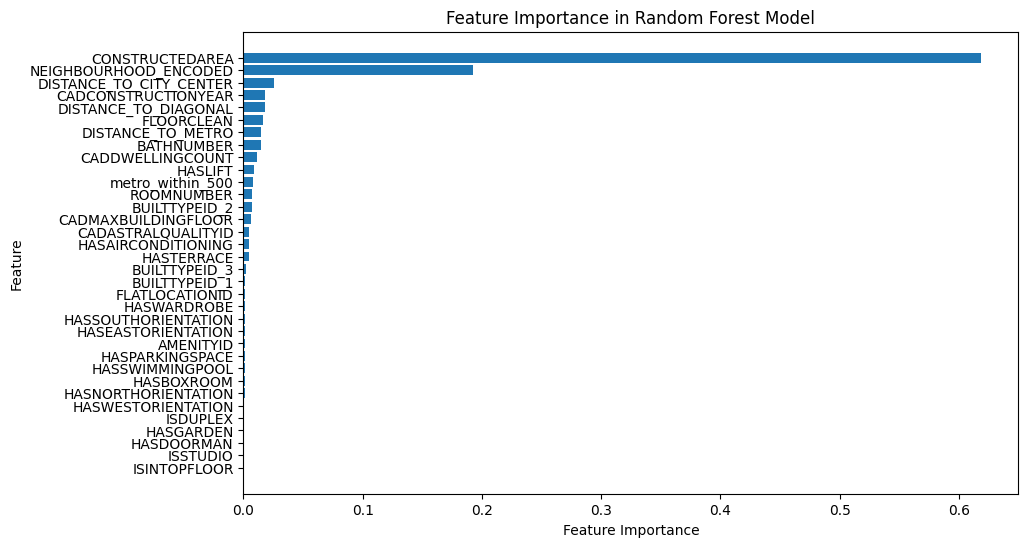

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f'MAE: {mae}')
print(f'MDAE: {mdae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

print(f'Best parameters found: {grid_search.best_params_}')

feature_importances = best_rf.feature_importances_
features = X.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb = XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_

y_pred = best_xgb.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f'MAE: {mae}')
print(f'MDAE: {mdae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

print(f'Best parameters found: {grid_search.best_params_}')

Fitting 5 folds for each of 6912 candidates, totalling 34560 fits


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


MAE: 0.11357728456543496
MDAE: 0.08306807880904721
RMSE: 0.15843951980475932
MAPE: 0.9022131472068953%
Best parameters found: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 1.0}
